# Predicting Customer Churn using Bank Customers

Customer churn (also known as customer attrition) occurs when a customer stops using a company's products or services.

The goal of this notebook is to understand and predict customer churn for a bank usig Random forest and SHAP values. 

Intially, performed Exploratory Data Analysis (EDA) to identify and visualise the factors that contribute to customer churn. Then I used Random Forest to predict whether a customer will churn or not. Accuracy of the model is 84.1%.


Most important factors are age, gender, geography, number of products and if a customer is active member or not

#### # Problem with this notebook 

1. Gender: one-hot encoding

2. Didn't normalize the data

3. Summary plot -> not as two different class i.e remained ad churned

4. Output from summary plot does not support the EDA graphs


![Klee - Visual Analytics](https://github.com/nikbearbrown/Visual_Analytics/blob/main/IMG/Klee_Visual_Analytics.png?raw=true)


YouTube - https://www.youtube.com/c/NikBearBrown    
GitHub - https://github.com/nikbearbrown/Visual_Analytics   
Kaggle - https://www.kaggle.com/nikbearbrown   
Klee.ai (Visual AI) - http://klee.ai  

## 2. Import libraries

Importing libraries:

Pandas for handling and analysing data,
Seaborn and Matplotlib for data visualization, and
Scikit-learn for building Machine Learning models.

In [26]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

import numpy as np
import pandas as pd
pd.set_option('precision', 3)
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('darkgrid')

from scipy.stats import chi2_contingency
from collections import Counter
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, recall_score, precision_score, auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import scikitplot as skplt

label_size = 17

plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['xtick.labelsize'] = label_size - 2
plt.rcParams['ytick.labelsize'] = label_size - 2
plt.rcParams['axes.titlesize'] = label_size
plt.rcParams['legend.fontsize'] = label_size - 2

random_state = 42
scoring_metric = 'recall'
comparison_dict = {}
comparison_test_dict = {}

%matplotlib inline

In [8]:
df = pd.read_csv('https://github.com/nikbearbrown/Visual_Analytics/raw/main/CSV/Churn_Modeling.csv')

print ('This dataset contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
df.head()

This dataset contains 10000 rows and 14 columns.


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


##### Details about the dataset:

It consists of 10000 observations and 12 variables. Independent variables contain information about customers. Dependent variable refers to customer abandonment status.

Variables:

RowNumber — corresponds to the record (row) number and has no effect on the output. This column will be removed.

CustomerId — contains random values and has no effect on customer leaving the bank. This column will be removed.

Surname — the surname of a customer has no impact on their decision to leave the bank. This column will be removed.

CreditScore — can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.

Geography — a customer’s location can affect their decision to leave the bank. We’ll keep this column.

Gender — it’s interesting to explore whether gender plays a role in a customer leaving the bank. We’ll include this column, too.

Age — this is certainly relevant, since older customers are less likely to leave their bank than younger ones.

Tenure — refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.

Balance — also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.

NumOfProducts — refers to the number of products that a customer has purchased through the bank.

HasCrCard — denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank. (0=No,1=Yes)

IsActiveMember — active customers are less likely to leave the bank, so we’ll keep this. (0=No,1=Yes)

EstimatedSalary — as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.

Exited — whether or not the customer left the bank. This is what we have to predict. (0=No,1=Yes)

The info() method can give us valuable information such as the number of non-null values and the type of each feature:

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


There are no missing values in the dataset. 

Columns 'RowNumber', 'CustomerID' and 'Surname' are specific to each customer and can be dropped:

In [10]:
df.drop(['RowNumber','CustomerId','Surname'],axis=1, inplace = True)
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

## 3. Exploratory data analysis

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.529,96.653,350.00,584.00,652.000,718.000,850.00
Age,10000.0,38.922,10.488,18.00,32.00,37.000,44.000,92.00
Tenure,10000.0,5.013,2.892,0.00,3.00,5.000,7.000,10.00
Balance,10000.0,76485.889,62397.405,0.00,0.00,97198.540,127644.240,250898.09
NumOfProducts,10000.0,1.530,0.582,1.00,1.00,1.000,2.000,4.00
HasCrCard,10000.0,0.706,0.456,0.00,0.00,1.000,1.000,1.00
IsActiveMember,10000.0,0.515,0.500,0.00,0.00,1.000,1.000,1.00
EstimatedSalary,10000.0,100090.240,57510.493,11.58,51002.11,100193.915,149388.247,199992.48
Exited,10000.0,0.204,0.403,0.00,0.00,0.000,0.000,1.00


The most important things to note are:

    1. The age of customers ranges from 18 to 92, with a mean value approximately equal to 40,
    2. The mean (and median) tenure is 5 years, so the majority of customers is loyal (tenure > 3), and
    3. Approximately 50% of customers are active.
    


In [15]:
colors = ['#00A5E0', '#DD403A']

fig = plt.figure(figsize = (5, 5))

# plot the graph
sns.countplot(x = 'Exited', data = df, palette = colors)

for index, value in enumerate(df['Exited'].value_counts()):
    label =  '{}%'.format(round( (value/df['Exited'].shape[0])*100, 2)) 
    plt.annotate(label, xy = (index - 0.18, value - 800), color = 'w', fontweight = 'bold', size = label_size)

plt.title('Number of Retained and Churned Customers')
plt.xticks([0, 1], ['Remained', 'Churned'])
plt.xlabel('Status')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

The bank kept 80% of its clientele.

The dataset is skewed/imbalanced since the number of instances in the 'Remained' class outnumbers the number of instances in the 'Churned' class by a lot. 

### Continuous Variables - Age, CreditScore, Balance, EstimatedSalary

By calling the hist() method we can plot a histogram for each of the four continuous numeric features:

In [21]:
continuous = ['Age','CreditScore','Balance','EstimatedSalary']
df[continuous].hist(figsize =(10,8), bins = 20, layout=(2,2), color = 'steelblue', edgecolor = 'firebrick', linewidth = 1.5)

/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'CreditScore'}>],
       [<AxesSubplot:title={'center':'Balance'}>,
        <AxesSubplot:title={'center':'EstimatedSalary'}>]], dtype=object)

### Observations:

1. 'Age' is slightly tail-heavy, i.e. it extends more further to the right of the median than to the left
2. Most values for 'CreditScore' are above 600
3. If we ignore the fist bin, 'Balance' follows a fairly normal distribution
4. The distribution of 'EstimatedSalary' is more or less uniform and provides little information.

### Categorical Variables - Geography, Gender, HasCreditCard,Tenure,NumberOfProducts, IsAxtiveMember

Let's plot a countplot for each categorical feature:

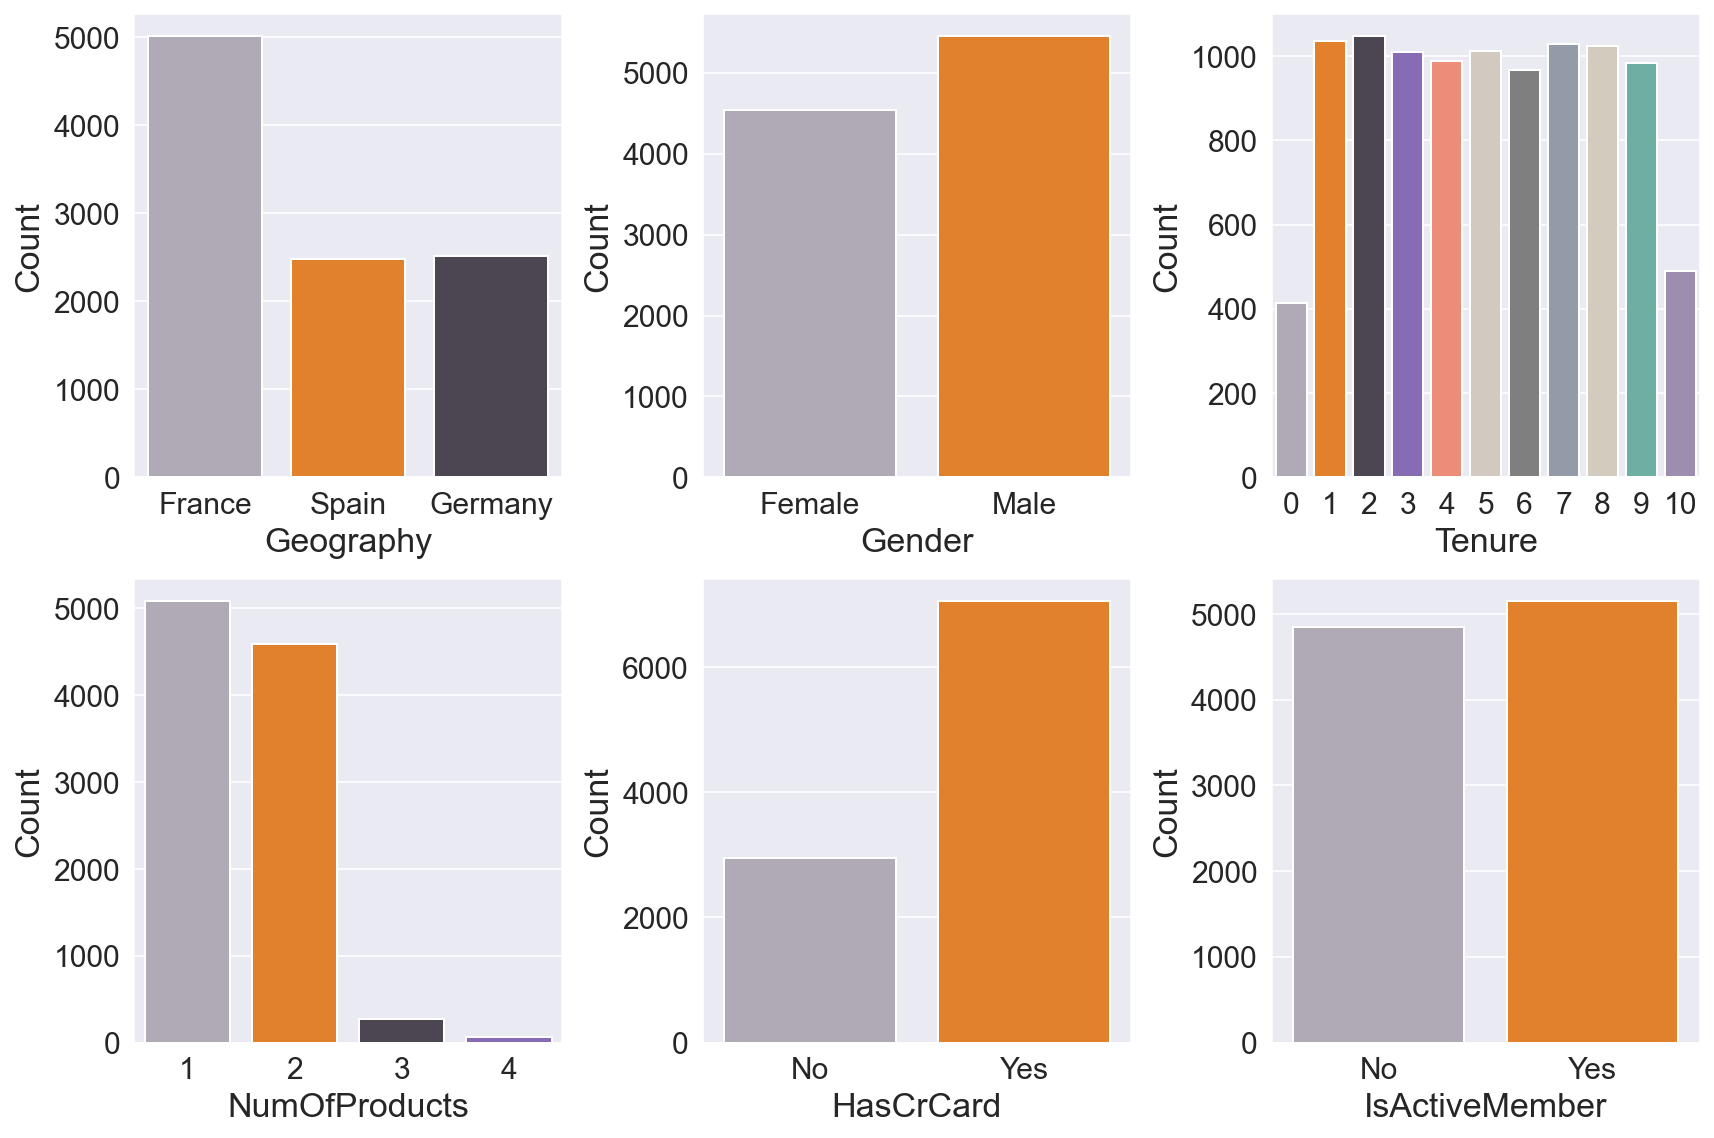

In [27]:
colors2 = ['#B0A8B9', '#ff7f0e', '#4B4453', '#845EC2', '#FF8066', '#D5CABD', 
           '#7f7f7f', '#8f9aaa', '#d4cebb',  '#63BAAA', '#9D88B3']

cat_vars = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
df_cat = df[cat_vars]

fig, ax = plt.subplots(2, 3, figsize = (12, 8))

for index, column in enumerate(df_cat.columns):

    plt.subplot(2, 3, index + 1)
    sns.countplot(x = column, data = df, palette = colors2)
    
    plt.ylabel('Count')
    if (column == 'HasCrCard' or column == 'IsActiveMember'): 
        plt.xticks([0, 1], ['No', 'Yes'])

plt.tight_layout();

### Observations:

1. The bank has customers in three countries (France, Spain, and Germany). Most customers are in France.
2. There are more male customers than females
3. Only a small percentage leaves within the first year. The count of customers in tenure years between 1 and 9 is almost the same,
4. Most of the customers have purchased 1 or 2 products, while a small portion has purchased 3 and 4,
5. A significant majority of customers has a credit card, and
6. Almost 50% of customers are not active.

In [28]:
def plot_continuous(feature):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
    
    sns.distplot(df_remained[feature], bins = 15, color = colors[0], label = 'Remained', 
                 hist_kws = dict(edgecolor = 'firebrick', linewidth = 1), ax = ax1, kde = False)
    sns.distplot(df_churned[feature], bins = 15, color = colors[1], label = 'Churned', 
                 hist_kws = dict(edgecolor = 'firebrick', linewidth = 1), ax = ax1, kde = False)
    ax1.set_title('{} distribution - Histogram'.format(feature))
    ax1.set_ylabel('Counts')
    ax1.legend()

    sns.boxplot(x = 'Exited', y = feature, data = df, palette = colors, ax = ax2)
    ax2.set_title('{} distribution - Box plot'.format(feature))
    ax2.set_xlabel('Status')
    ax2.set_xticklabels(['Remained', 'Churned'])

    plt.tight_layout();

In [29]:
def plot_categorical(feature):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
    sns.countplot(x = feature, hue = 'Exited', data = df, palette = colors, ax = ax1)
    ax1.set_ylabel('Counts')
    ax1.legend(labels = ['Retained', 'Churned'])
    
    sns.barplot(x = feature, y = 'Exited', data = df, palette = colors2 , ci = None, ax = ax2)
    ax2.set_ylabel('Churn rate')
    
    if (feature == 'HasCrCard' or feature == 'IsActiveMember'):
        ax1.set_xticklabels(['No', 'Yes'])
        ax2.set_xticklabels(['No', 'Yes'])
    
    plt.tight_layout();

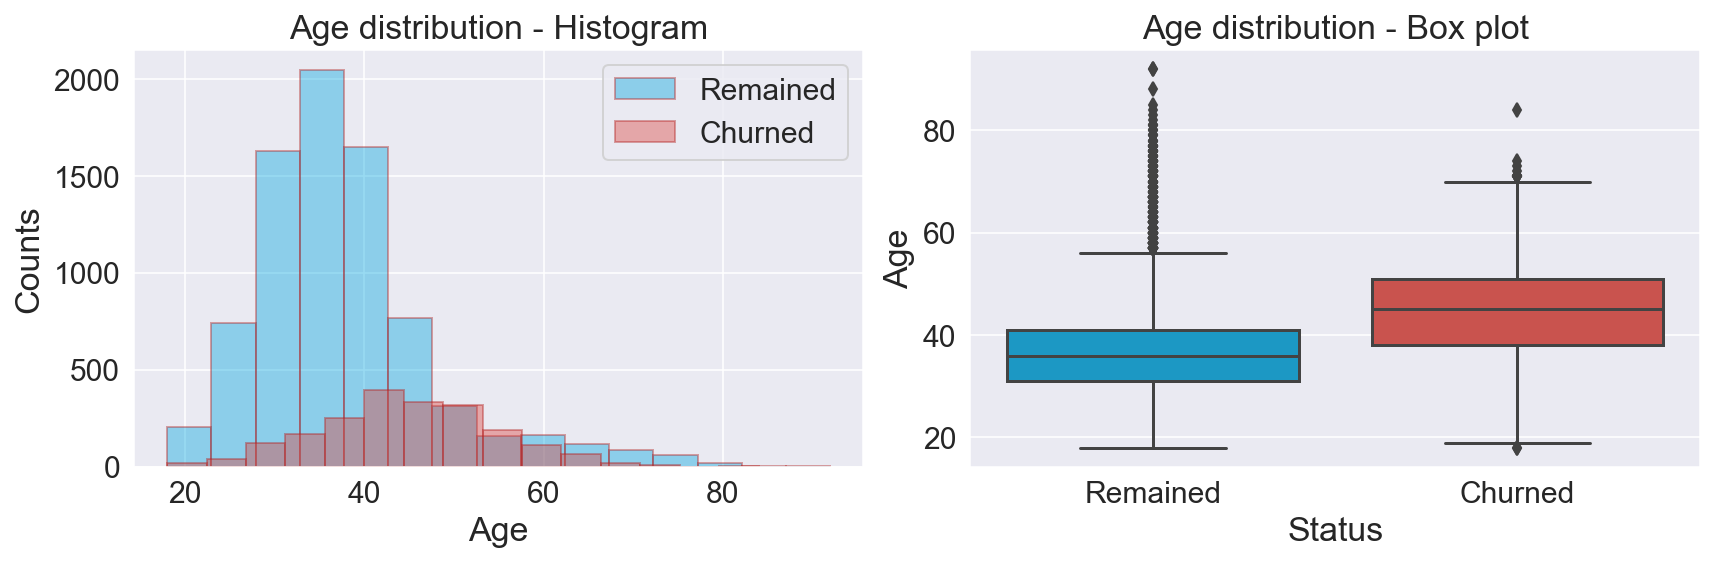

In [30]:
df_churned = df[df['Exited'] == 1]
df_remained = df[df['Exited'] == 0]

plot_continuous('Age')

There is a clear difference between age groups since older customers are more likely to churn. This could potentially indicate that preferences change with age, and the bank hasn't adapted its strategy to meet the requirements of older customers.

It can be clearly observed that 50% of the people likely to churn at the age of 50.

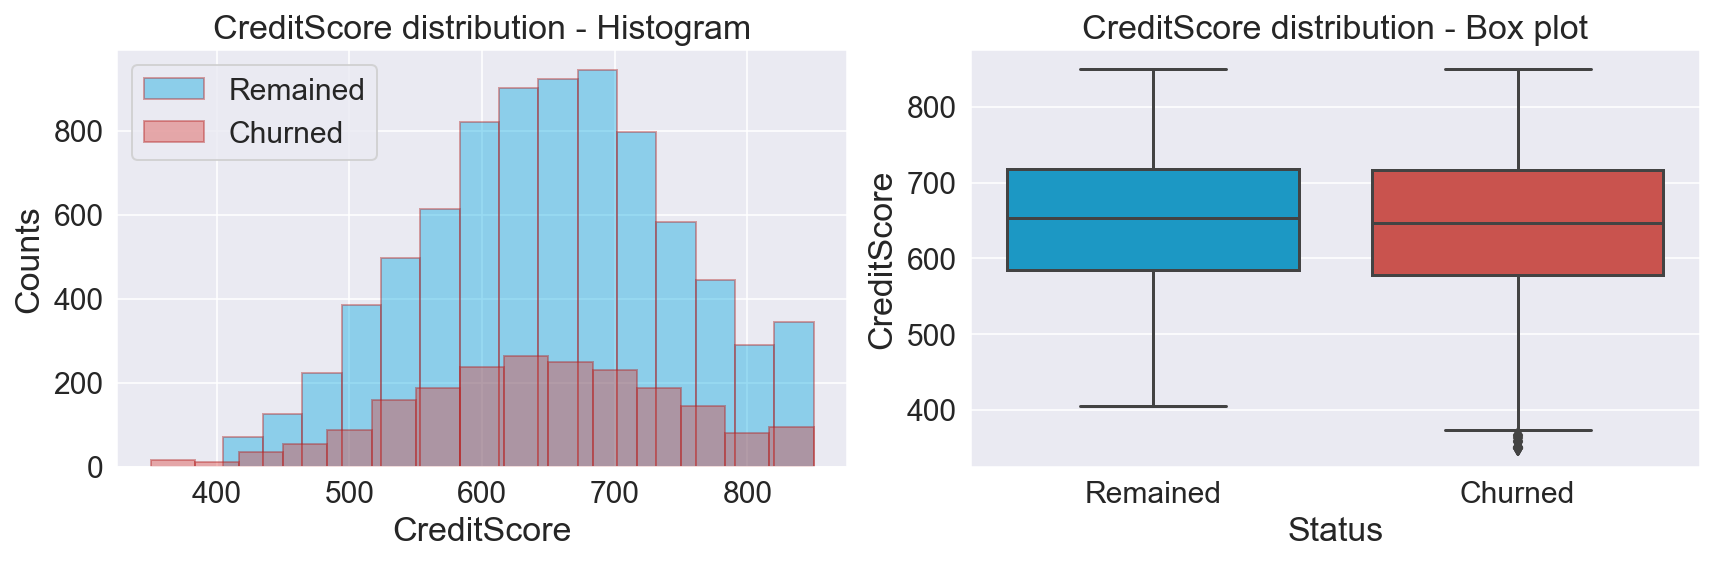

In [31]:
plot_continuous('CreditScore')

There is no significant difference between retained and churned customers in terms of their credit score.

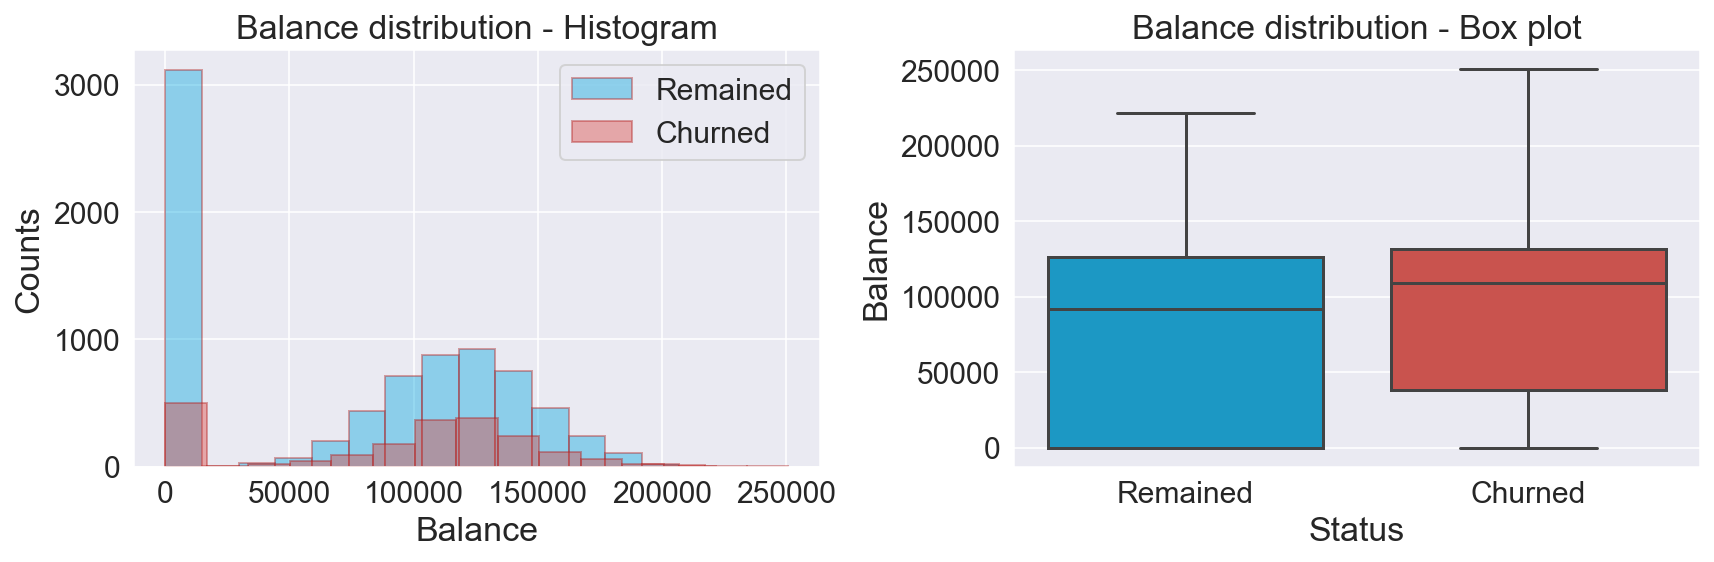

In [32]:
plot_continuous('Balance')

The two distributions are quite similar. There is a big percentage of non-churned customers with a low account balance.

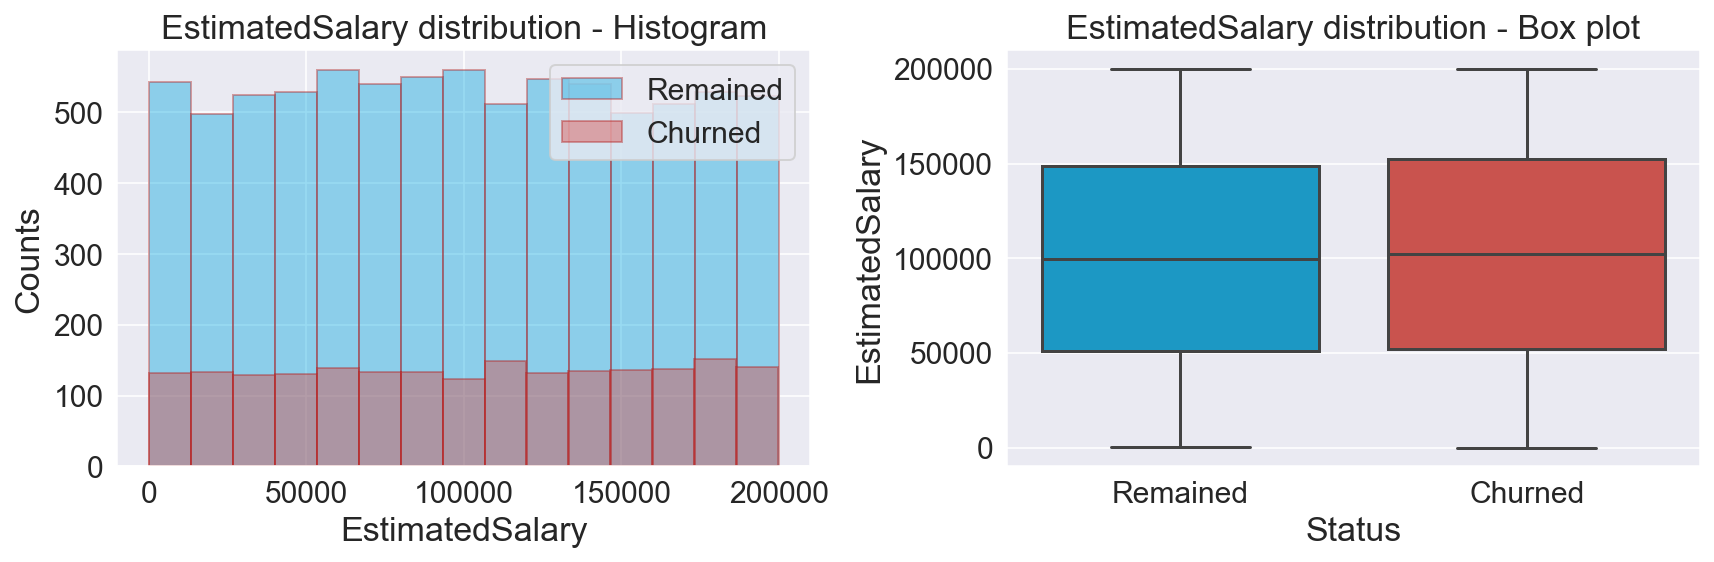

In [33]:
plot_continuous('EstimatedSalary')

Both churned and retained customers display a similar uniform distribution for their salary. Consequently, we can conclude that salary doesn't have a significant effect on the likelihood to churn.



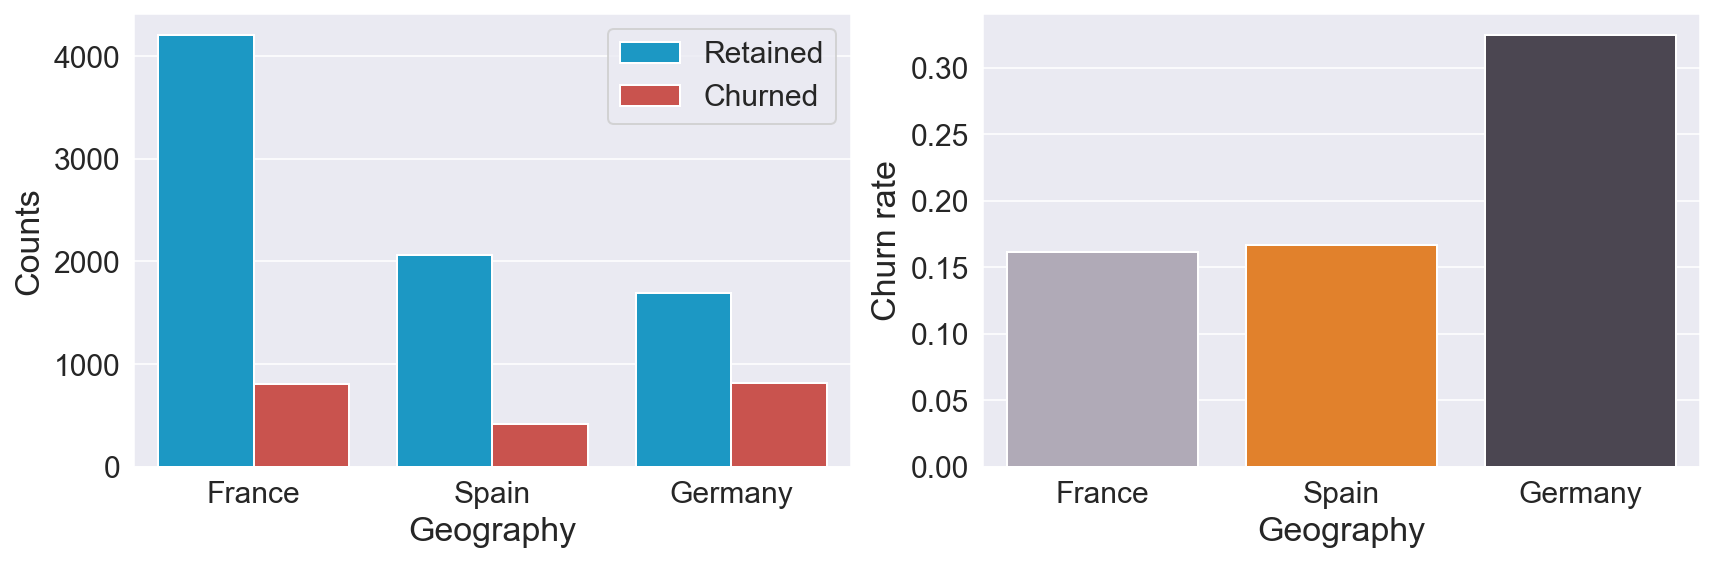

In [34]:
plot_categorical('Geography')

Customers in Germany are more likely to churn than customers in the other two countries (the churn rate is almost double compared to Spain and France). Many reasons could explain this finding such as higher competition or different preferences for German customers.

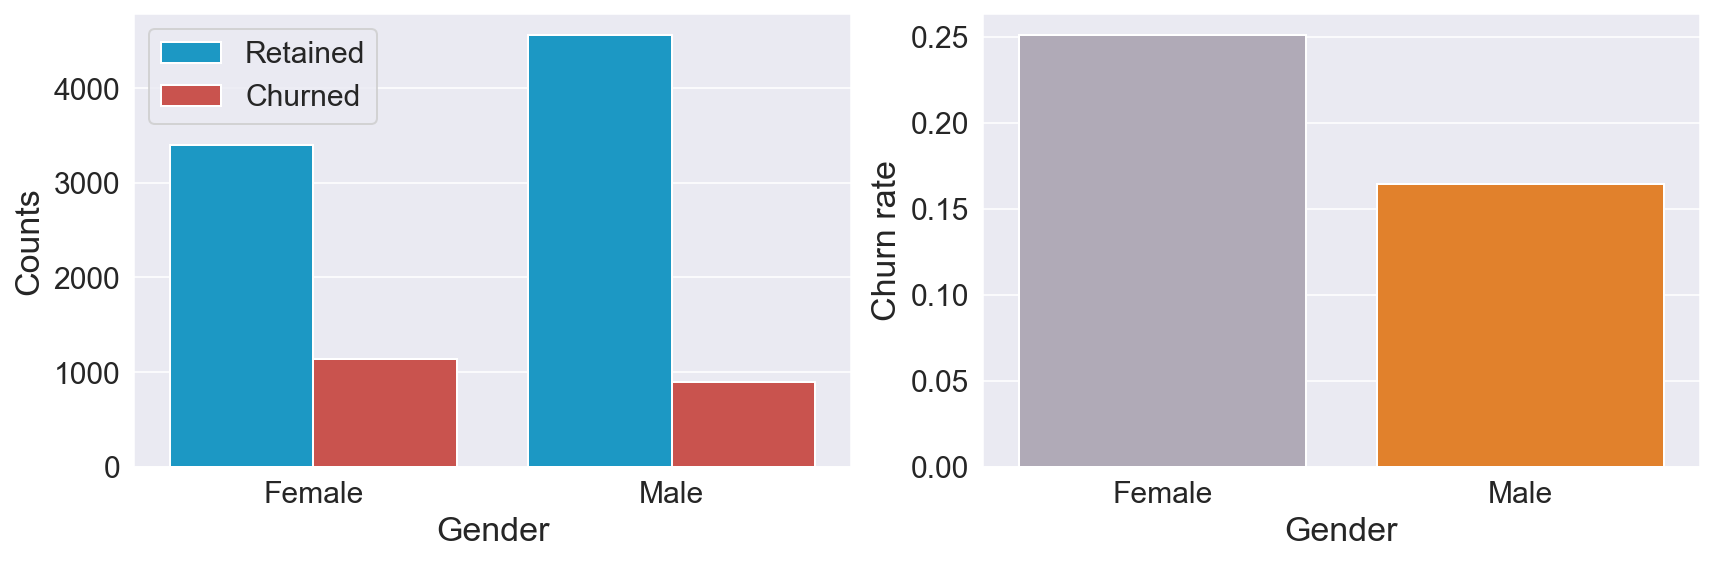

In [35]:
plot_categorical('Gender')

Female customers are more likely to churn.   ( which is more imp age or gender) 

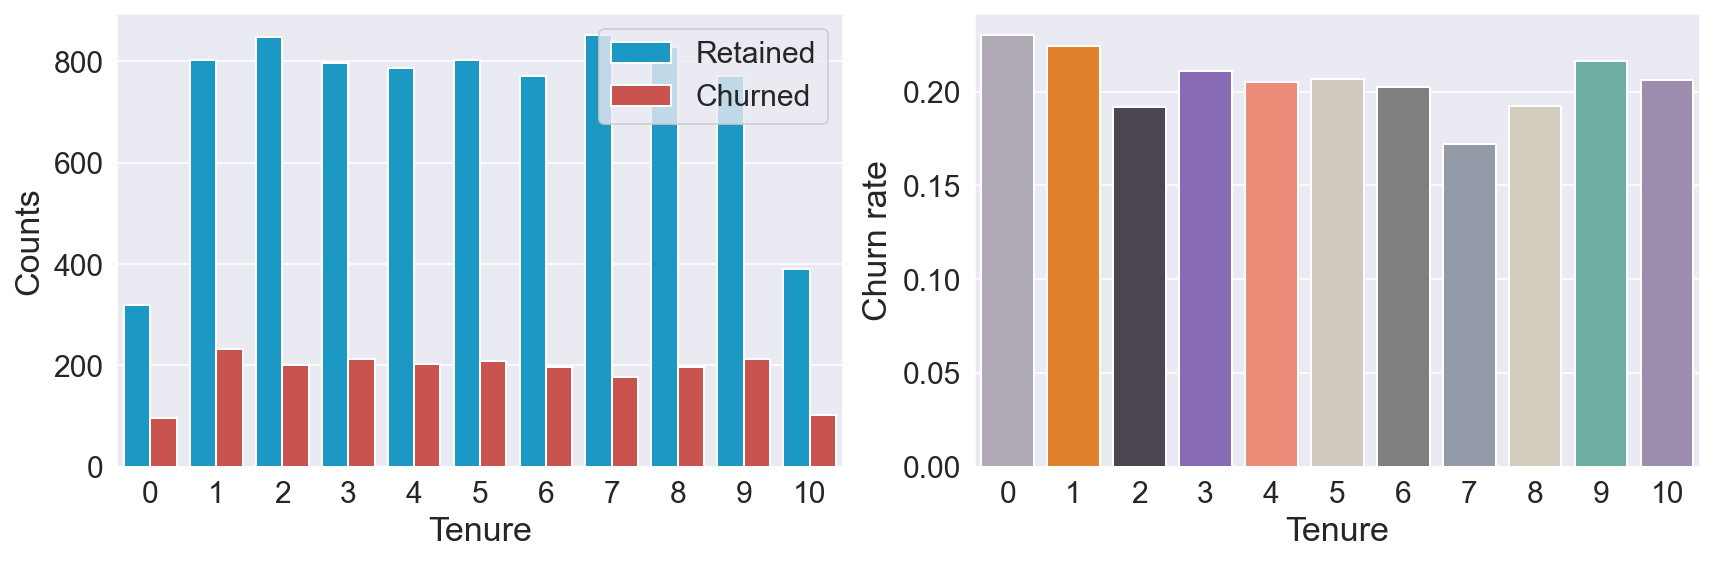

In [36]:
plot_categorical('Tenure')

Tenure does not seem to affect the customer churn. It is most likely for customers to churn either at the start or end of the tenure

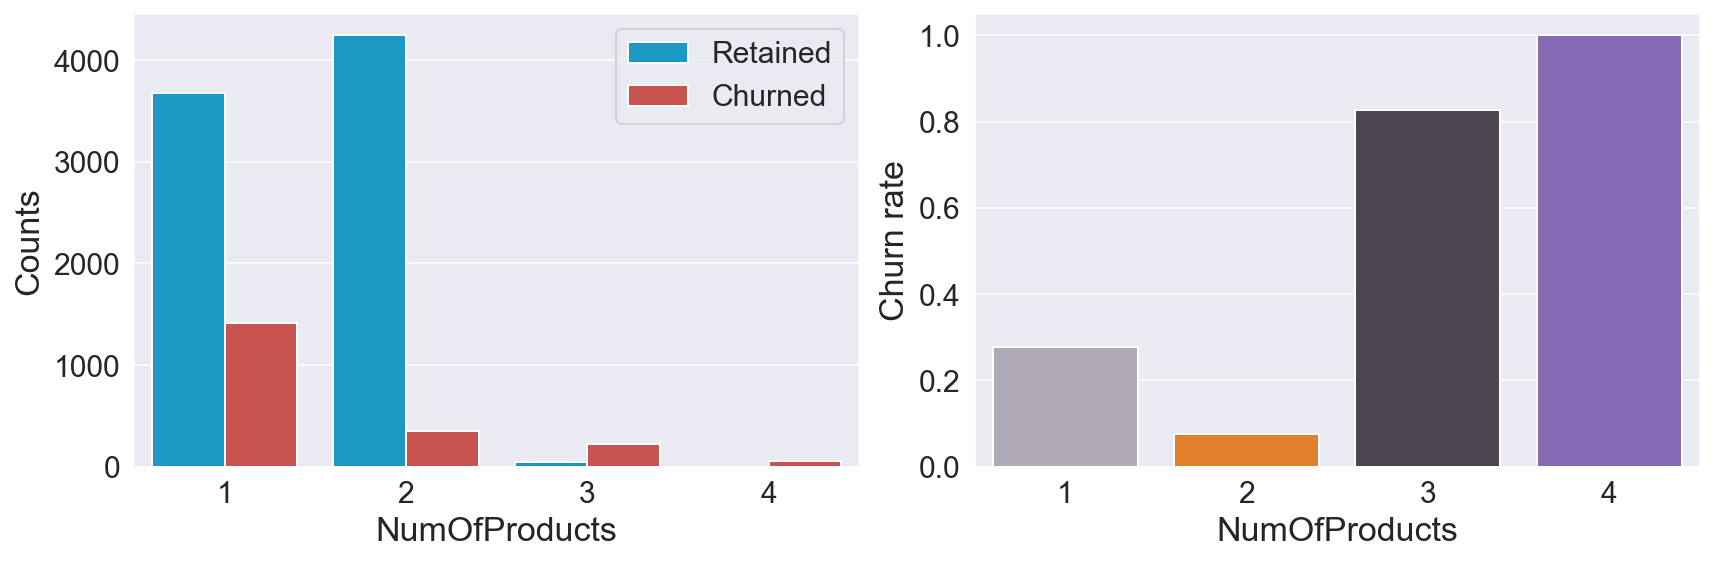

In [37]:
plot_categorical('NumOfProducts')

having 3 or 4 products significantly increases the likelihood of churn.

I am not sure how to interpret this result. It could potentially mean that the bank is unable to properly support customers with more products which in turn increases customer dissatisfaction.

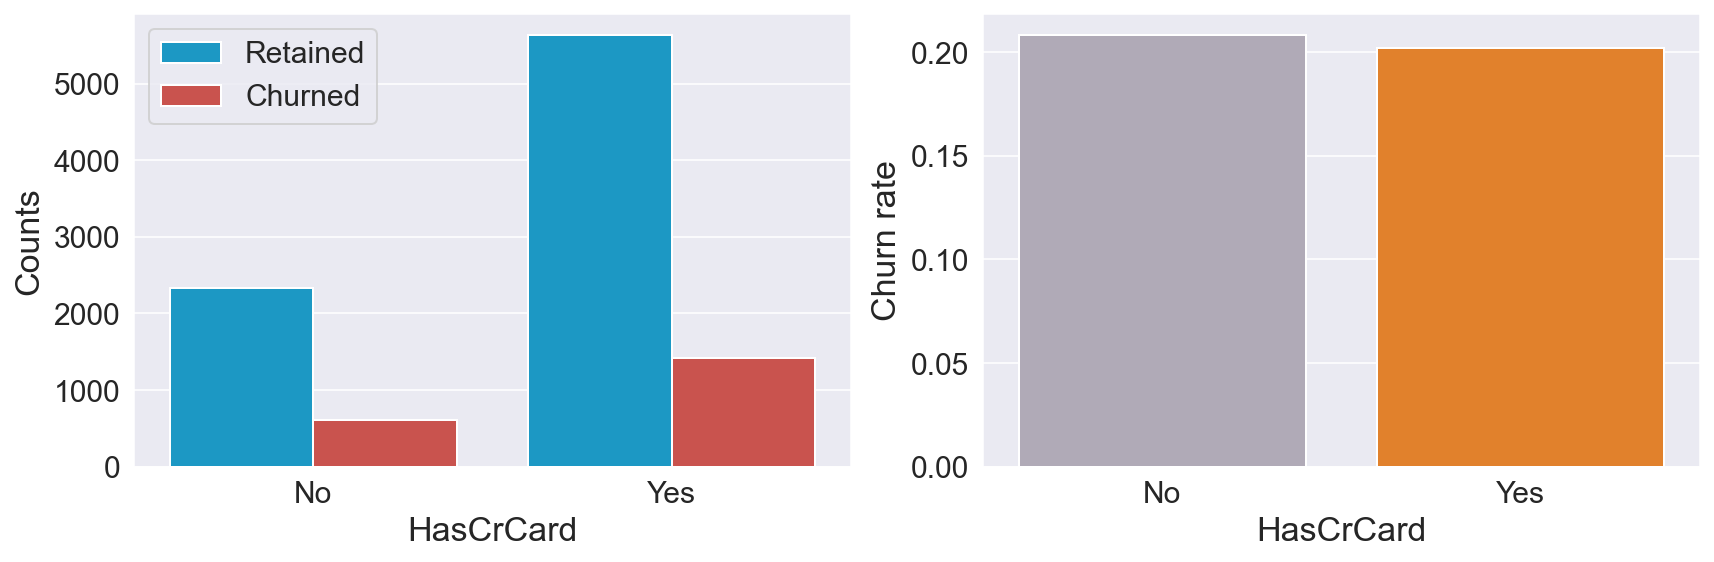

In [38]:
plot_categorical('HasCrCard')

Having a credit card doesn't seem to affect the churn rate.

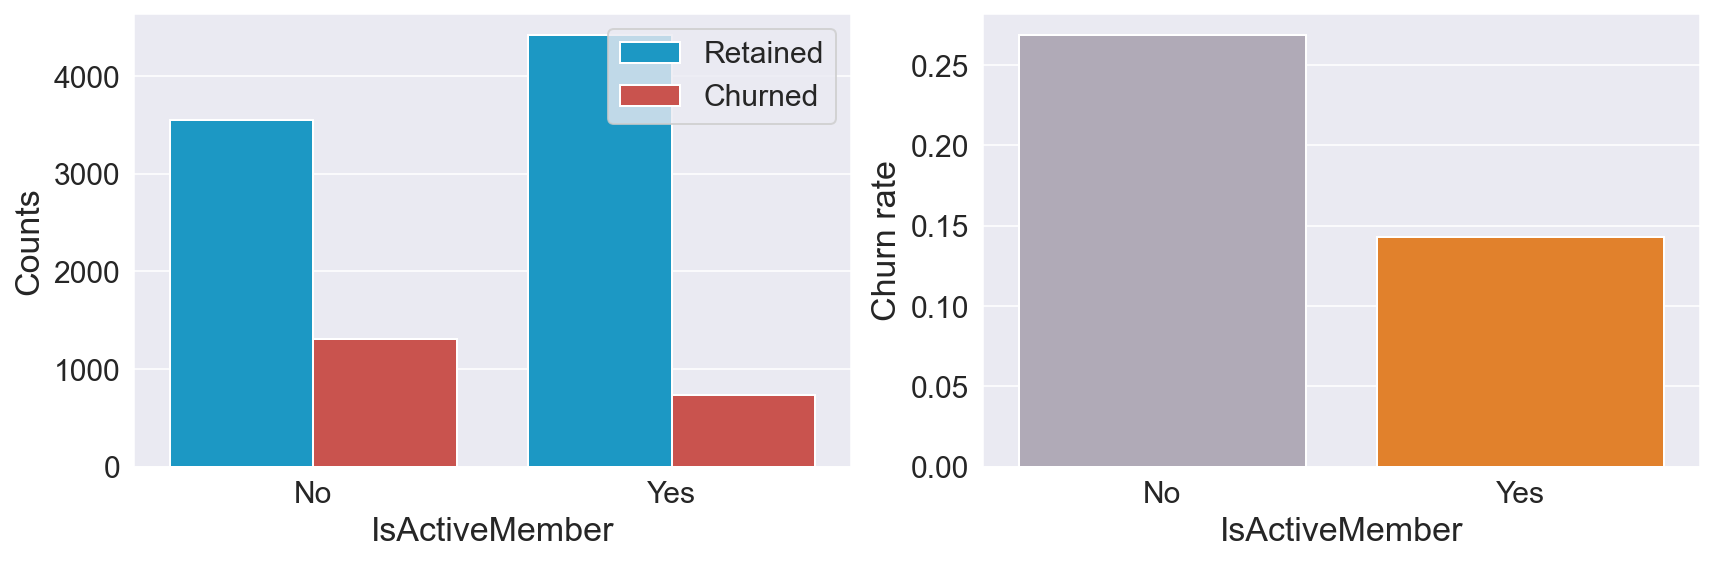

In [39]:
plot_categorical('IsActiveMember')

It's not a surprise that inactive customers are more likely to churn. A big portion of the clientele is inactive; therefore, the bank will definitely benefit from changing its policy so that more customers become active.

## 4. Data Preprocessing

Data preprocessing is the process of converting raw data into a well-readable format that is suitable for building and training Machine Learning models.

Encoding Categorical Features:

Machine learning algorithms usually require that all input (and output) features are numeric. Consequently, categorical features need to be converted (encoded) to numbers before using them for building models.

In this dataset, geography and gender was encoded.

In [40]:
# One-Hot encoding the categorical attributes
list_cat = ['Geography', 'Gender']
df = pd.get_dummies(df, columns = list_cat, prefix = list_cat)
#df.head()

In [41]:
# Arrange columns by data type for easier manipulation
continuous_vars = ['CreditScore',  'Age', 'Tenure', 'Balance','NumOfProducts', 'EstimatedSalary']
cat_vars = ['HasCrCard', 'IsActiveMember','Gender_Female','Gender_Male','Geography_France',
            'Geography_Germany','Geography_Spain']
df = df[continuous_vars + cat_vars + ['Exited']]
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,HasCrCard,IsActiveMember,Gender_Female,Gender_Male,Geography_France,Geography_Germany,Geography_Spain,Exited
0,619,42,2,0.00,1,101348.88,1,1,1,0,1,0,0,1
1,608,41,1,83807.86,1,112542.58,0,1,1,0,0,0,1,0
2,502,42,8,159660.80,3,113931.57,1,0,1,0,1,0,0,1
3,699,39,1,0.00,2,93826.63,0,0,1,0,1,0,0,0
4,850,43,2,125510.82,1,79084.10,1,1,1,0,0,0,1,0


In [42]:
# New dataframe with important features
df_bank = df[['CreditScore','Tenure','EstimatedSalary','HasCrCard','Geography_Germany','IsActiveMember', 
              'Gender_Female','Gender_Male','Age', 'Geography_France','Balance','Geography_Spain','NumOfProducts','Exited']]

df_bank.head()

,CreditScore,Tenure,EstimatedSalary,HasCrCard,Geography_Germany,IsActiveMember,Gender_Female,Gender_Male,Age,Geography_France,Balance,Geography_Spain,NumOfProducts,Exited
0,619,2,101348.88,1,0,1,1,0,42,1,0.00,0,1,1
1,608,1,112542.58,0,0,1,1,0,41,0,83807.86,1,1,0
2,502,8,113931.57,1,0,0,1,0,42,1,159660.80,0,3,1
3,699,1,93826.63,0,0,0,1,0,39,1,0.00,0,2,0
4,850,2,79084.10,1,0,1,1,0,43,0,125510.82,1,1,0


## 7. Train test split

The code below splits the training data. Using 75%  of the training data for actual training purposes, and once training is completed, using the remaining  25%  of the training data to check the training accuracy of the trained model.

In [45]:
x = df_bank.drop('Exited', axis=1)  
y = df_bank.Exited  

# Splitting the dataset in training and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)


In [46]:
from xgboost import XGBClassifier
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:13:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [47]:
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [48]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [49]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 85.48%


## 7. Interpretation using SHAP

TreeExplainer is a package for explaining and interpreting predictions of tree-based machine learning models. The notion of interpretability is based on how close the inclusion of a feature takes the model toward its final prediction. For this reason, the result of this approach is "feature contributions" to the predictions.

The basic idea is to decompose each prediction into feature contribution components. For a dataset with n features, each prediction on the dataset is calculated as

prediction ≈ baseline probability at tree root + contribution feature 1 + ... + contribution feature n

Feature contributions are provided at the level of observations, features, and targets.

In [50]:
#SHAP import
import shap


explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train,approximate=False, check_additivity=False)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


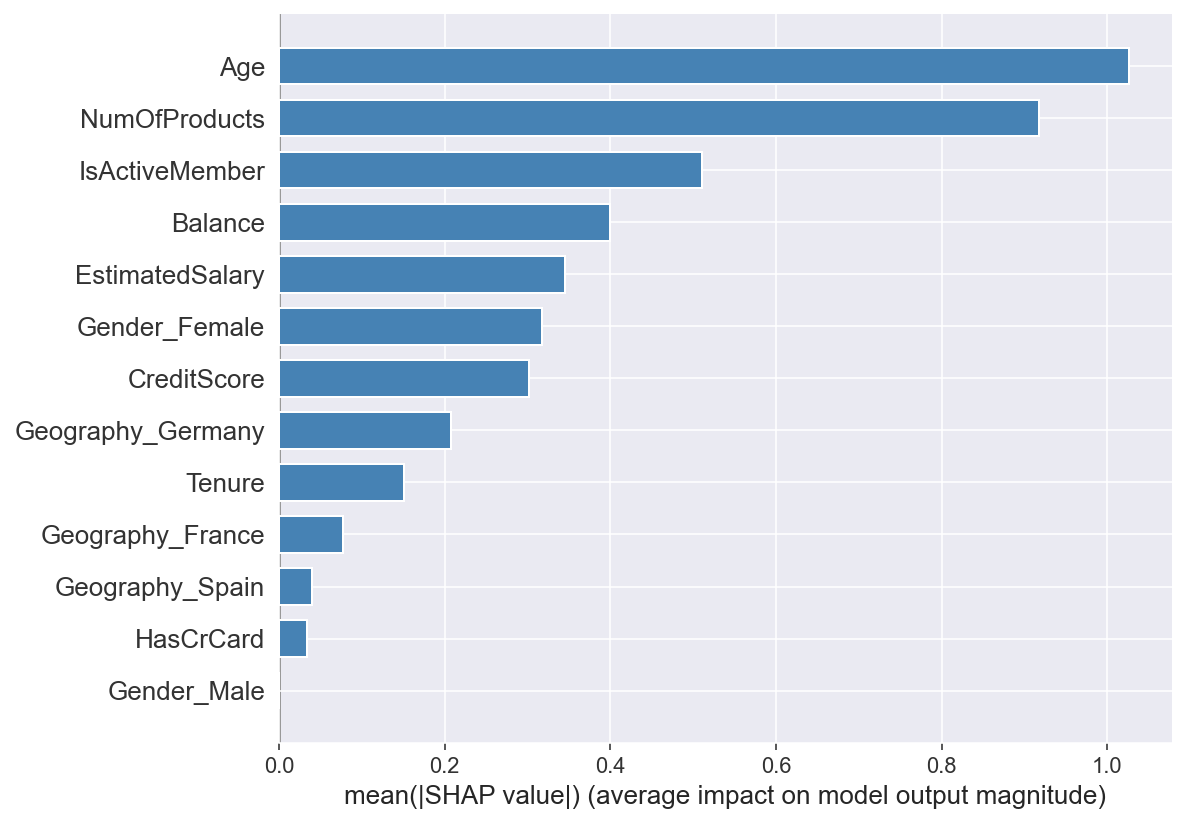

In [51]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train, plot_type="bar", color='steelblue')

Most important factors are age, gender, geography, number of products and if a customer is active member or not

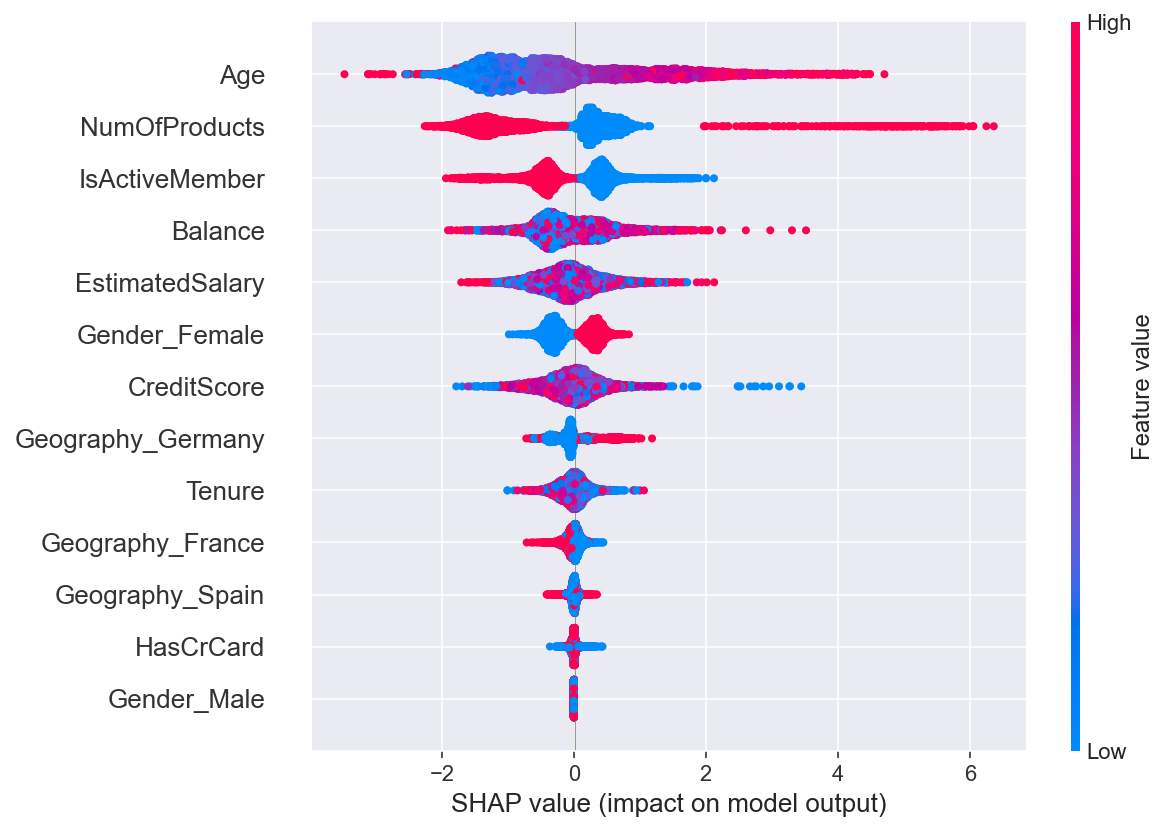

In [52]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

age : high age remain wth bank?? (wrong)

male: if a person is not male then he remains as customers

female: if a person is not female the she remains as cutomers (not correct)....

#### Force plot

In [53]:
shap.initjs()
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], x.iloc[0,:])

In [54]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], x.iloc[1,:])

In [55]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[1,:], x.iloc[0,:])

In [56]:
shap.force_plot(explainer.expected_value, shap_values[1,:], x.iloc[1,:])

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


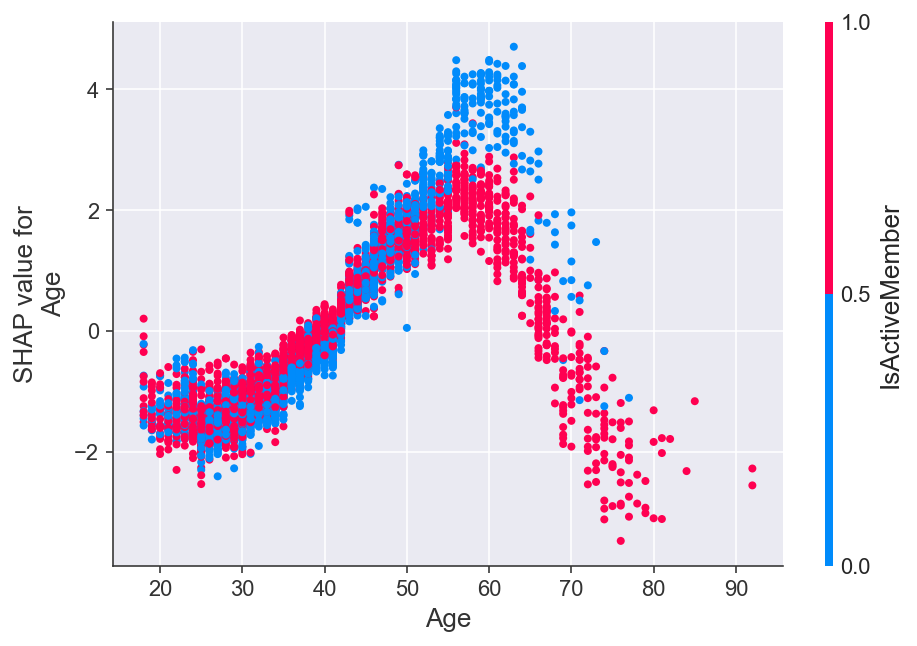

In [57]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Age", shap_values, X_train)

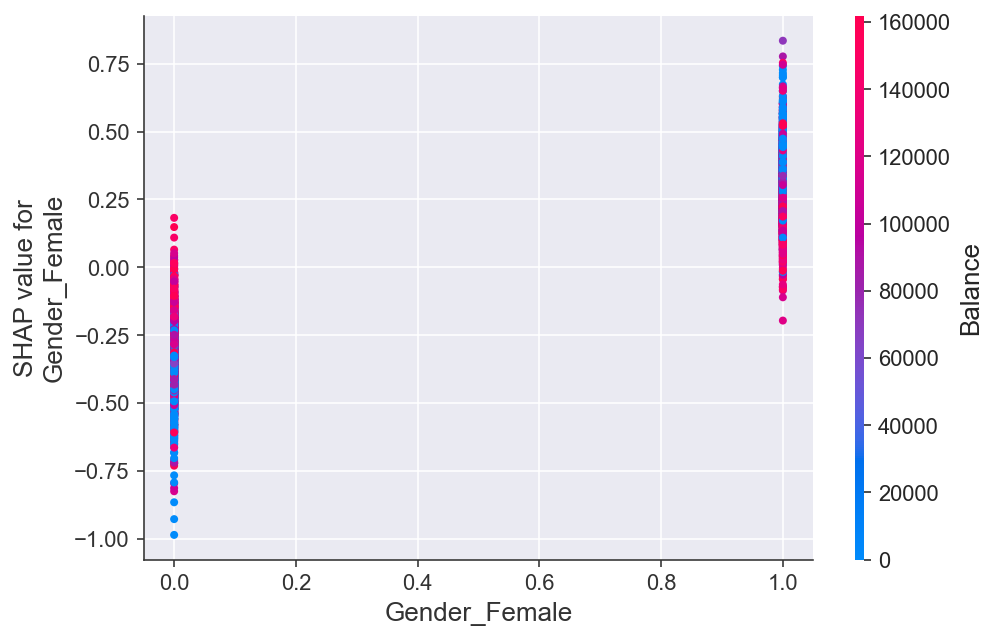

In [58]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Gender_Female", shap_values, X_train)

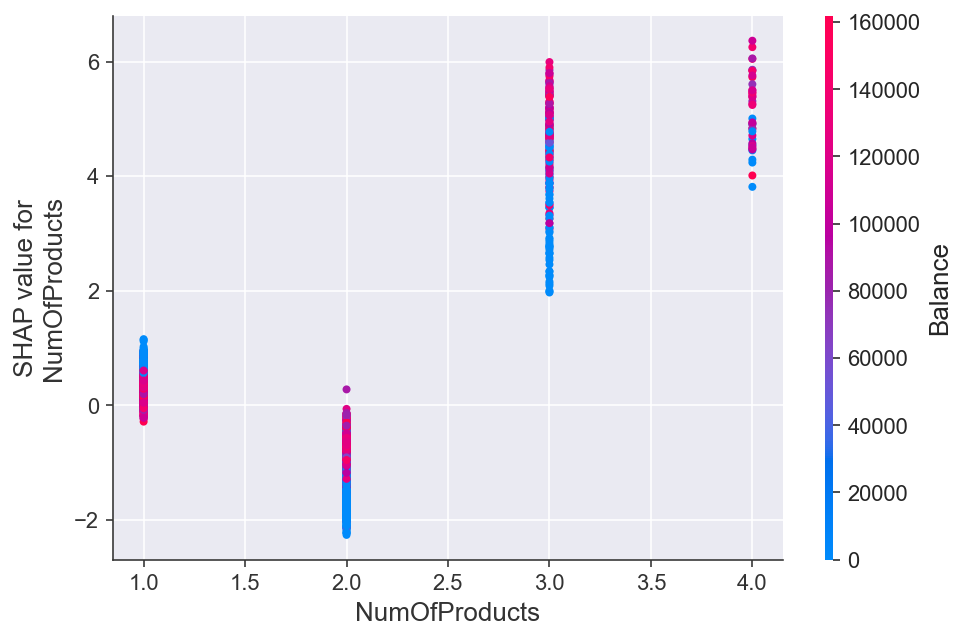

In [59]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("NumOfProducts", shap_values, X_train)

In [60]:
shap.TreeExplainer(model).shap_interaction_values(x)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


array([[[ 2.73031890e-01, -2.95576453e-02,  4.62834165e-03, ...,
         -1.50774270e-02,  1.40416725e-02, -1.45227909e-02],
        [-2.95576528e-02,  5.32433614e-02,  3.00231464e-02, ...,
          3.28068286e-02,  3.38091515e-03,  2.21416652e-02],
        [ 4.62832674e-03,  3.00231725e-02,  8.61363765e-03, ...,
          4.44389880e-03, -8.37726332e-03, -1.57773495e-04],
        ...,
        [-1.50774494e-02,  3.28067616e-02,  4.44390625e-03, ...,
         -6.63701892e-02, -8.20759498e-03,  2.44109660e-01],
        [ 1.40416771e-02,  3.38091701e-03, -8.37725401e-03, ...,
         -8.20758939e-03,  1.58693045e-02, -6.92993402e-04],
        [-1.45227984e-02,  2.21418347e-02, -1.57807022e-04, ...,
          2.44109586e-01, -6.93012029e-04,  4.68580008e-01]],

       [[ 4.46097180e-02, -4.04958427e-02,  2.60490477e-02, ...,
         -7.83305764e-02,  1.68024115e-02, -1.55466981e-02],
        [-4.04958688e-02,  8.81185085e-02,  1.23682320e-01, ...,
          5.26044071e-02, -9.70313512e

In [61]:
# takes a couple minutes since SHAP interaction values take a factor of 2 * # features
# more time than SHAP values to compute, since this is just an example we only explain
# the first 2,000 people in order to run quicker
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(x.iloc[:2000,:])

## SHAP Interaction Value Summary Plot

A summary plot of a SHAP interaction value matrix plots a matrix of summary plots with the main effects on the diagonal and the interaction effects off the diagonal.

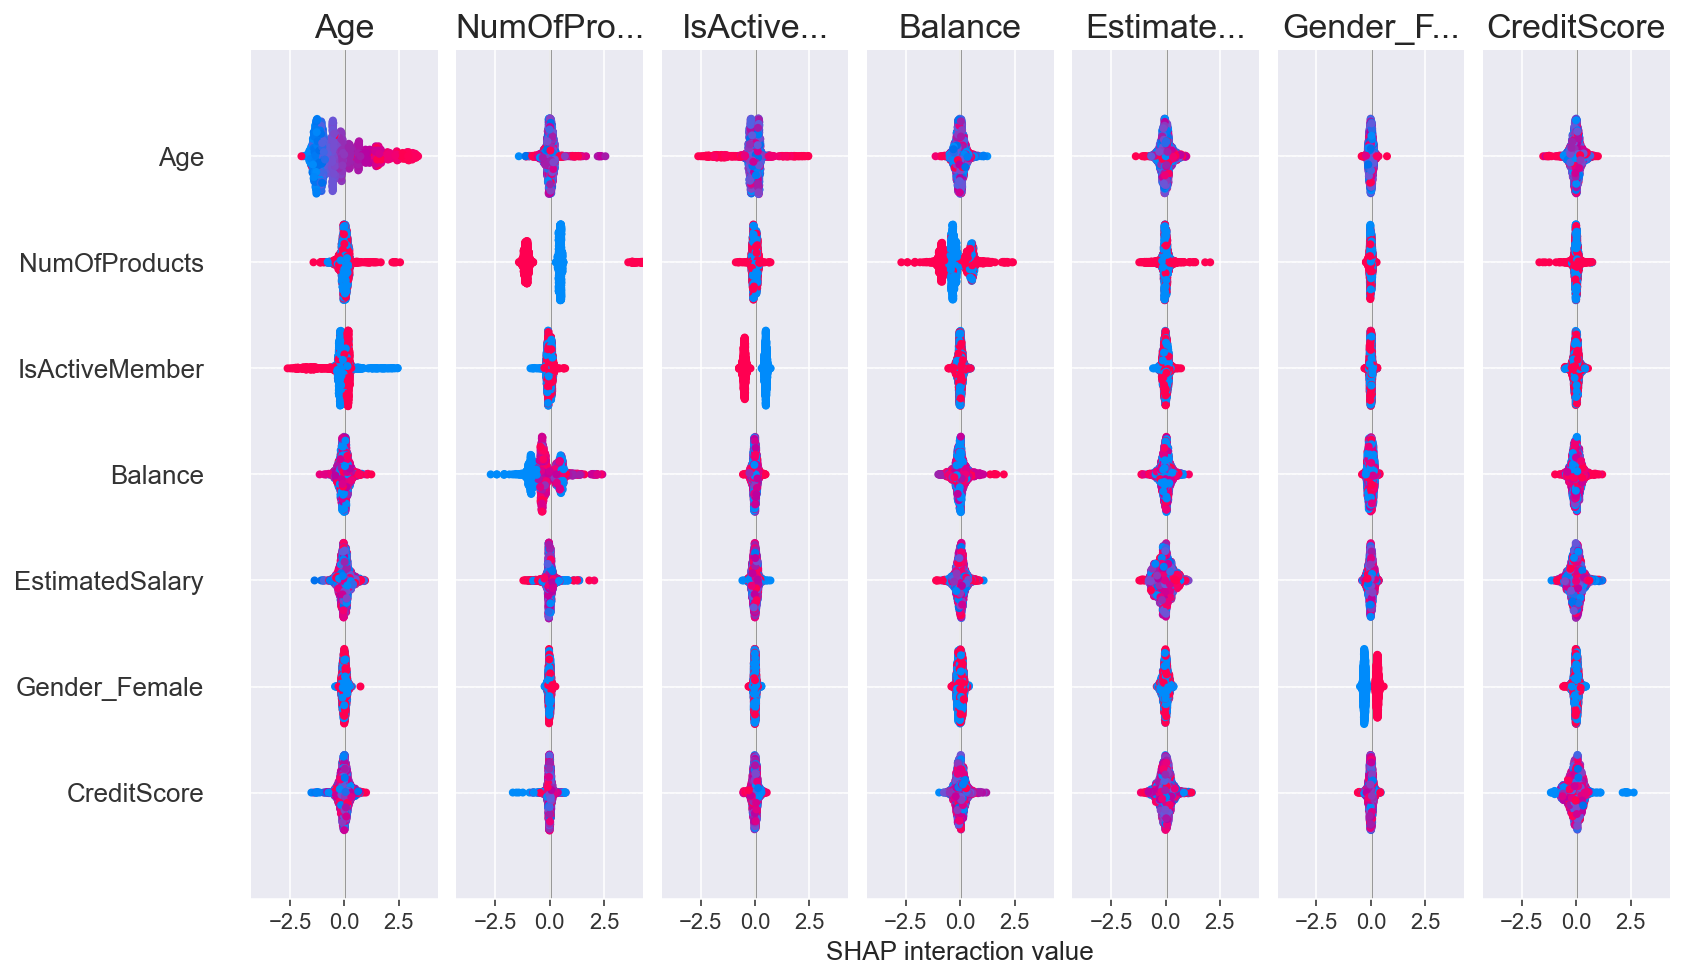

In [62]:
shap.summary_plot(shap_interaction_values, x.iloc[:2000,:])

## SHAP Interaction Value Dependence Plots
Running a dependence plot on the SHAP interaction values a allows us to separately observe the main effects and the interaction effects.

Below we plot the main effects for age and some of the interaction effects for age. It is informative to compare the main effects plot of age with the earlier SHAP value plot for age. The main effects plot has no vertical dispersion because the interaction effects are all captured in the off-diagonal terms.

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


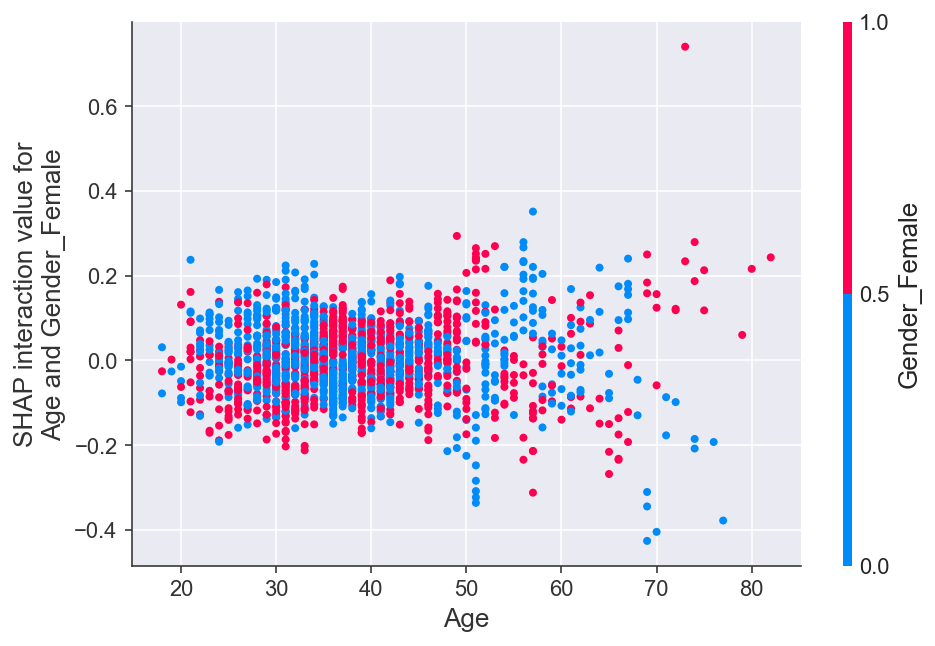

In [63]:
shap.dependence_plot(
    ("Age", "Gender_Female"),
    shap_interaction_values, x.iloc[:2000,:]
    #display_features=x_display.iloc[:2000,:]
)

In [66]:
X_output = X_test.copy()
X_output.loc[:,'predict if customer will churn'] = np.round(model.predict(X_output),2)

random_picks = np.arange(1,330,50)
S = X_output.iloc[random_picks]
S

,CreditScore,Tenure,EstimatedSalary,HasCrCard,Geography_Germany,IsActiveMember,Gender_Female,Gender_Male,Age,Geography_France,Balance,Geography_Spain,NumOfProducts,predict if customer will churn
6045,549,1,128499.94,1,1,1,1,0,37,0,130622.34,0,2,0
7853,730,7,33373.26,1,0,0,1,0,47,1,0.00,0,1,1
4617,812,10,156906.15,1,0,1,0,1,24,1,0.00,0,2,0
9060,685,1,70221.13,0,0,1,1,0,33,1,0.00,0,3,0
3834,734,6,112973.34,0,0,0,1,0,39,0,92126.26,1,2,0
3960,535,0,145986.35,0,0,1,0,1,47,1,160729.10,0,1,0
2700,564,4,53520.03,1,0,0,0,1,31,1,0.00,0,2,0


In [67]:
shap.initjs()

def shap_plot(j):
    # compute SHAP values
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value[j], shap_values_Model[j], S.iloc[[j]])
    return(p)

In [68]:
# mean of X train
X_train.mean()

CreditScore            650.230
Tenure                   5.032
EstimatedSalary      99424.028
HasCrCard                0.707
Geography_Germany        0.252
IsActiveMember           0.517
Gender_Female            0.453
Gender_Male              0.547
Age                     38.924
Geography_France         0.499
Balance              76291.380
Geography_Spain          0.248
NumOfProducts            1.532
dtype: float64

In [69]:
# mean of Y test
y_test.mean()

0.2092

In [70]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

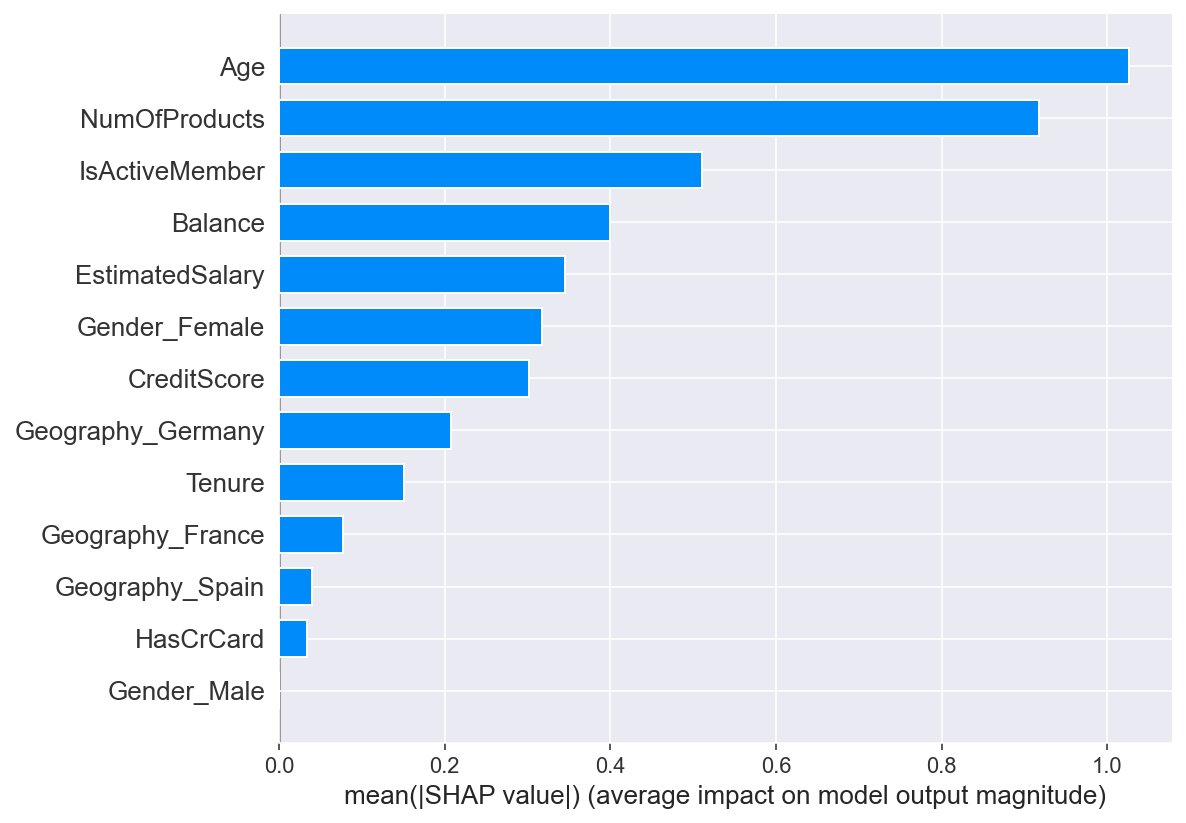

In [73]:
shap.summary_plot(shap_values, X_test, plot_type="bar")